## Summary and Fidnings

At its core, GQA represents a thoughtful optimization of the traditional Multi-Head Attention mechanism. Our analysis revealed two distinct innovations that work together but serve different purposes. The first innovation involves reducing the number of key and value heads while maintaining the full complement of query heads. The second introduces a caching mechanism for key and value projections during inference.

The insight about where GQA's optimization occurs is particularly significant. Rather than addressing the quadratic complexity of attention computation itself, GQA optimizes the linear projection stage that happens earlier in the pipeline. Think of it like optimizing the ingredients preparation in cooking rather than changing the cooking process itself. This explains why we still see quadratic memory growth with sequence length in our benchmarks – the fundamental matrix multiplication at the heart of attention remains unchanged.

The choice of maintaining full query heads while reducing key and value heads reveals sophisticated design thinking. By preserving all query heads, we maintain the model's ability to attend to different aspects of the input with fine granularity. It's analogous to having many observers (queries) who can each form their own unique perspective, even though they're all looking at the same set of simplified reference points (keys and values). This design choice helps explain why GQA maintains strong performance despite using fewer resources.
Our benchmarking experiments revealed an interesting gap between theoretical predictions and practical results. While theoretical analysis suggested consistent memory savings, our real-world measurements showed more complex behavior, especially as sequence lengths increased. This divergence highlights the importance of considering both theoretical and empirical analysis when evaluating architectural innovations.

Looking ahead, GQA's modular nature makes it particularly valuable as a building block for more advanced architectures. Its compatibility with other optimization techniques like Flash Attention demonstrates how different optimizations can work together when they target different parts of the attention mechanism. This modularity suggests that understanding GQA deeply – as we're doing now – provides valuable insights for implementing more advanced mechanisms like MLA.

## Implmentations

### MHA Implemetation

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class MultiHeadAttention(nn.Module):
    """
    Transformer Scaled Dot Product Attention Module
    Args:
        d_model: Total dimension of the model.
        num_head: Number of attention heads.
        dropout: Dropout rate for attention scores.
        bias: Whether to include bias in linear projections.

    Inputs:
        sequence: input sequence for self-attention and the query for cross-attention
        key_value_state: input for the key, values for cross-attention
    """
    def __init__(self, d_model, num_head, dropout=0.1, bias=True): # infer d_k, d_v, d_q from d_model
        super().__init__()  # Missing in the original implementation
        assert d_model % num_head == 0, "d_model must be divisible by num_head"
        self.d_model = d_model
        self.num_head = num_head
        self.d_head=d_model//num_head
        self.dropout_rate = dropout  # Store dropout rate separately

        # linear transformations
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)
        self.output_proj = nn.Linear(d_model, d_model, bias=bias)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # Initiialize scaler
        self.scaler = float(1.0 / math.sqrt(self.d_head)) # Store as float in initialization
        

    def forward(self, sequence, key_value_states = None, att_mask=None):
        """Input shape: [batch_size, seq_len, d_model=num_head * d_head]"""
        batch_size, seq_len, model_dim = sequence.size()

        # Check only critical input dimensions
        assert model_dim == self.d_model, f"Input dimension {model_dim} doesn't match model dimension {self.d_model}"
        if key_value_states is not None:
            assert key_value_states.size(-1) == self.d_model, \
            f"Cross attention key/value dimension {key_value_states.size(-1)} doesn't match model dimension {self.d_model}"


        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None
        
        # Linear projections and reshape for multi-head
        Q_state = self.q_proj(sequence)
        if is_cross_attention:
            kv_seq_len = key_value_states.size(1)
            K_state = self.k_proj(key_value_states)
            V_state = self.v_proj(key_value_states)
        else:
            kv_seq_len = seq_len
            K_state = self.k_proj(sequence)
            V_state = self.v_proj(sequence)

        #[batch_size, self.num_head, seq_len, self.d_head]
        Q_state = Q_state.view(batch_size, seq_len, self.num_head, self.d_head).transpose(1,2) 
            
        # in cross-attention, key/value sequence length might be different from query sequence length
        K_state = K_state.view(batch_size, kv_seq_len, self.num_head, self.d_head).transpose(1,2)
        V_state = V_state.view(batch_size, kv_seq_len, self.num_head, self.d_head).transpose(1,2)

        # Scale Q by 1/sqrt(d_k)
        Q_state = Q_state * self.scaler
    
    
        # Compute attention matrix: QK^T
        self.att_matrix = torch.matmul(Q_state, K_state.transpose(-1,-2)) 

    
        # apply attention mask to attention matrix
        if att_mask is not None and not isinstance(att_mask, torch.Tensor):
            raise TypeError("att_mask must be a torch.Tensor")

        if att_mask is not None:
            self.att_matrix = self.att_matrix + att_mask
        
        # apply softmax to the last dimension to get the attention score: softmax(QK^T)
        att_score = F.softmax(self.att_matrix, dim = -1)
    
        # apply drop out to attention score
        att_score = self.dropout(att_score)
    
        # get final output: softmax(QK^T)V
        att_output = torch.matmul(att_score, V_state)
    
        # concatinate all attention heads
        att_output = att_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.num_head*self.d_head) 
    
        # final linear transformation to the concatenated output
        att_output = self.output_proj(att_output)

        assert att_output.size() == (batch_size, seq_len, self.d_model), \
        f"Final output shape {att_output.size()} incorrect"

        return att_output

### GQA Implemtation 

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GroupedQueryAttention(nn.Module):
    """
    Grouped Query Attention Module (GQA)
    Key differences from standard MHA:
    1. Separate number of heads for queries vs keys/values
    2. Support for KV caching during inference
    3. Head repetition logic for sharing KV heads across query heads
    """
    def __init__(
        self, 
        d_model, 
        num_query_heads, 
        num_kv_heads=None,  # If None, defaults to num_query_heads (becomes standard MHA)
        dropout=0.1, 
        bias=True,
        max_batch_size=32,   # For KV cache sizing
        max_seq_len=2048     # For KV cache sizing
    ):
        super().__init__()
        
        # Setup head dimensions
        self.d_model = d_model
        self.num_query_heads = num_query_heads
        self.num_kv_heads = num_kv_heads if num_kv_heads is not None else num_query_heads
        # Verify dimensions match up
        assert d_model % num_query_heads == 0, f"d_model ({d_model}) must be divisible by num_query_heads ({num_query_heads})"
        self.d_head = d_model // num_query_heads
        
        # Calculate repetition factor for KV sharing
        assert num_query_heads % self.num_kv_heads == 0, "Query heads must be divisible by KV heads"
        self.num_key_value_groups = num_query_heads // self.num_kv_heads
        
        # Linear projections with appropriate output dimensions
        self.q_proj = nn.Linear(d_model, num_query_heads * self.d_head, bias=bias)
        # Note: KV projections use num_kv_heads instead of num_query_heads
        self.k_proj = nn.Linear(d_model, self.num_kv_heads * self.d_head, bias=bias)
        self.v_proj = nn.Linear(d_model, self.num_kv_heads * self.d_head, bias=bias)
        self.output_proj = nn.Linear(num_query_heads * self.d_head, d_model, bias=bias)

        # Dropout and scaling
        self.dropout = nn.Dropout(p=dropout)
        self.scale = float(1.0 / math.sqrt(self.d_head))
        
        # Initialize KV cache for inference
        self.cache_k = torch.zeros(
            (max_batch_size, max_seq_len, self.num_kv_heads, self.d_head)
        )
        self.cache_v = torch.zeros(
            (max_batch_size, max_seq_len, self.num_kv_heads, self.d_head)
        )
        
    def repeat_kv_heads(self, kv: torch.Tensor) -> torch.Tensor:
        """
        Repeats KV heads to match number of query heads.
        Input shape: [batch_size, seq_len, num_kv_heads, head_dim]
        Output shape: [batch_size, seq_len, num_query_heads, head_dim]
        """
        if self.num_key_value_groups == 1:
            return kv
        
        # Repeat KV heads to match number of query heads
        batch_size, seq_len, num_kv_heads, d_head = kv.shape
        kv = kv.unsqueeze(3)  # [b, s, kv_heads, 1, d]
        kv = kv.expand(-1, -1, -1, self.num_key_value_groups, -1)  # [b, s, kv_heads, groups, d]
        return kv.reshape(batch_size, seq_len, self.num_query_heads, d_head)

    def forward(
        self, 
        sequence, 
        key_value_states=None,
        att_mask=None,
        use_cache=False,
        start_pos: int = 0
    ):
        """
        Forward pass supporting both standard attention and cached inference
        Args:
            sequence: Input sequence [batch_size, seq_len, d_model]
            key_value_states: Optional states for cross-attention
            att_mask: Optional attention mask
            use_cache: Whether to use KV caching (for inference)
            start_pos: Position in sequence when using KV cache
        """
        batch_size, seq_len, _ = sequence.shape
        
        # Linear projections and reshape for multi-head
        # Note different shapes for Q vs K/V due to grouped attention
        q = self.q_proj(sequence).view(
            batch_size, seq_len, self.num_query_heads, self.d_head
        )
        
        if key_value_states is not None:  # Cross attention
            kv_seq_len = key_value_states.size(1)
            k = self.k_proj(key_value_states)
            v = self.v_proj(key_value_states)
        else:  # Self attention
            kv_seq_len = seq_len
            k = self.k_proj(sequence)
            v = self.v_proj(sequence)
            
        # Reshape KV with fewer heads than Q
        k = k.view(batch_size, kv_seq_len, self.num_kv_heads, self.d_head)
        v = v.view(batch_size, kv_seq_len, self.num_kv_heads, self.d_head)
        
        if use_cache:
            # Update KV cache with current tokens
            self.cache_k = self.cache_k.to(q.device)
            self.cache_v = self.cache_v.to(q.device)
            
            self.cache_k[:batch_size, start_pos:start_pos + kv_seq_len] = k
            self.cache_v[:batch_size, start_pos:start_pos + kv_seq_len] = v
            
            # Use all cached + current KV
            k = self.cache_k[:batch_size, :start_pos + kv_seq_len]
            v = self.cache_v[:batch_size, :start_pos + kv_seq_len]
            
            # Update attention mask for cached sequence length
            if att_mask is not None:
                att_mask = att_mask[:, :, :start_pos + kv_seq_len]
        
        # Repeat KV heads to match number of query heads
        k = self.repeat_kv_heads(k)
        v = self.repeat_kv_heads(v)
        
        # Scale Q and transpose for attention computation
        q = q * self.scale
        q = q.transpose(1, 2)  # [batch_size, num_query_heads, seq_len, head_dim]
        k = k.transpose(1, 2)  # [batch_size, num_query_heads, kv_seq_len, head_dim]
        v = v.transpose(1, 2)  # [batch_size, num_query_heads, kv_seq_len, head_dim]
        
        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-1, -2))
        
        if att_mask is not None:
            scores = scores + att_mask
            
        # Apply softmax and dropout
        att_weights = F.softmax(scores, dim=-1)
        att_weights = self.dropout(att_weights)
        
        # Apply attention weights to values
        output = torch.matmul(att_weights, v)
        
        # Reshape and apply output projection
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.output_proj(output)
        
        return output

## testing

### Theoritcal Cache Size Calculation

In [7]:
import torch
import torch.nn as nn
import math

def calculate_cache_size(seq_len, num_heads, head_dim, num_layers, is_gqa=False, num_groups=None):
    """
    Calculate KV cache size in number of elements (floats) for different attention mechanisms.
    
    For MHA: Cache size = 2 * num_heads * head_dim * seq_len * num_layers
    For GQA: Cache size = 2 * num_groups * head_dim * seq_len * num_layers
    
    The factor of 2 comes from having both K and V caches.
    """
    if is_gqa:
        # For GQA, we use number of groups (fewer than number of heads)
        num_kv_heads = num_groups if num_groups is not None else num_heads
        return 2 * num_kv_heads * head_dim * seq_len * num_layers
    else:
        # For MHA, we use full number of heads
        return 2 * num_heads * head_dim * seq_len * num_layers

# Example configuration (similar to a small transformer model)
config = {
    'seq_len': 1024,      # Sequence length
    'num_heads': 32,      # Number of attention heads
    'head_dim': 64,       # Dimension of each head
    'num_layers': 12      # Number of transformer layers
}

# Calculate cache sizes for both mechanisms
mha_cache = calculate_cache_size(**config, is_gqa=False)
# Using 8 groups for GQA (4x fewer than MHA heads)
gqa_cache = calculate_cache_size(**config, is_gqa=True, num_groups=8)

print(f"Cache size comparison for sequence length {config['seq_len']}:")
print(f"MHA cache elements: {mha_cache:,}")
print(f"GQA cache elements: {gqa_cache:,}")
print(f"Memory reduction ratio: {mha_cache/gqa_cache:.2f}x")

# Calculate memory usage in MB (assuming float32 precision - 4 bytes per float)
bytes_per_float = 4
print(f"\nApproximate memory usage:")
print(f"MHA: {mha_cache * bytes_per_float / (1024*1024):.2f} MB")
print(f"GQA: {gqa_cache * bytes_per_float / (1024*1024):.2f} MB")

# Calculate maximum sequence length possible with GQA for same memory budget as MHA
gqa_max_seq = (mha_cache * bytes_per_float) / (gqa_cache/config['seq_len'] * bytes_per_float)
print(f"\nWith same memory budget, GQA could handle sequence length: {int(gqa_max_seq):,}")

# Let's also compare with DeepSeek-V2 configuration
print("\nDeepSeek-V2 style comparison:")
# In DeepSeek-V2, they mention GQA with 2.25 groups achieves similar performance
deepseek_gqa = calculate_cache_size(**config, is_gqa=True, num_groups=2.25)
print(f"DeepSeek-V2 GQA cache elements: {deepseek_gqa:,}")
print(f"Reduction ratio vs MHA: {mha_cache/deepseek_gqa:.2f}x")

Cache size comparison for sequence length 1024:
MHA cache elements: 50,331,648
GQA cache elements: 12,582,912
Memory reduction ratio: 4.00x

Approximate memory usage:
MHA: 192.00 MB
GQA: 48.00 MB

With same memory budget, GQA could handle sequence length: 4,096

DeepSeek-V2 style comparison:
DeepSeek-V2 GQA cache elements: 3,538,944.0
Reduction ratio vs MHA: 14.22x


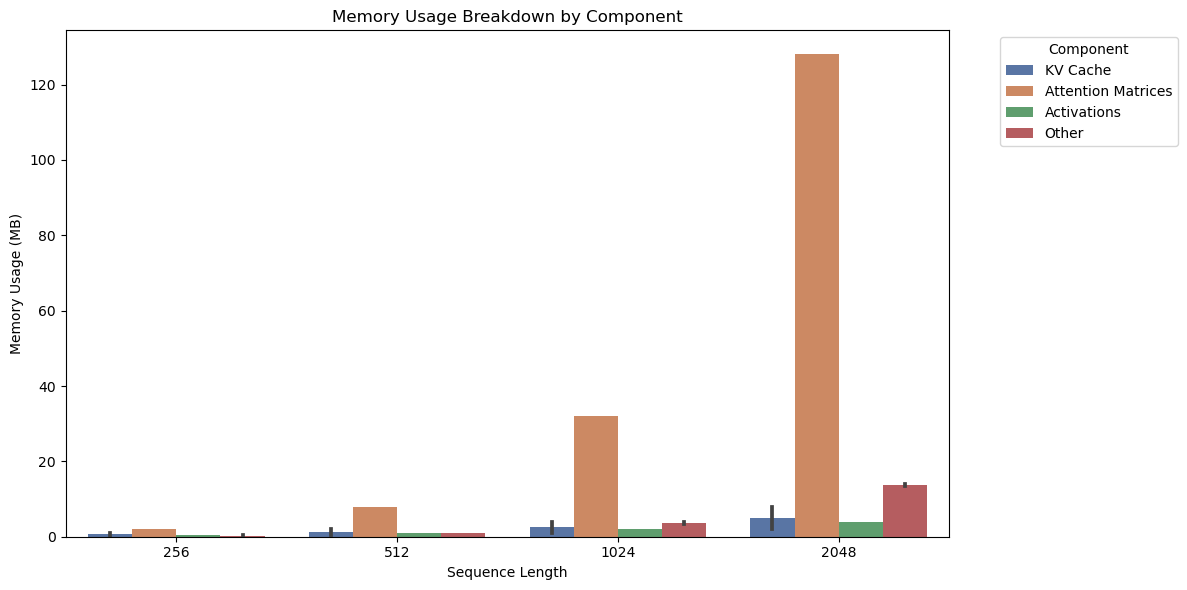

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_memory_breakdown(config):
    """
    Plot memory breakdown for MHA vs GQA
    
    Args:
        config: dict with keys:
            - d_model: model dimension
            - num_heads: number of attention heads
            - num_kv_heads: number of KV heads for GQA
            - batch_size: batch size
    """
    # Model parameters
    d_model = config['d_model']
    num_heads = config['num_heads']
    num_kv_heads = config['num_kv_heads']
    batch_size = config['batch_size']
    head_dim = d_model // num_heads
    
    # Sequence lengths to analyze
    seq_lengths = [256, 512, 1024, 2048]
    components = ['KV Cache', 'Attention Matrices', 'Activations', 'Other']
    
    data = []
    for seq_len in seq_lengths:
        # MHA memory components (in bytes)
        mha_kv = 2 * num_heads * head_dim * seq_len * 4  # KV cache (float32)
        mha_att = batch_size * num_heads * seq_len * seq_len * 4  # Attention matrices
        mha_act = d_model * seq_len * 4  # Activations
        mha_total = mha_kv + mha_att + mha_act
        mha_other = mha_total * 0.1  # Other overhead
        
        # GQA memory components
        gqa_kv = 2 * num_kv_heads * head_dim * seq_len * 4
        gqa_att = batch_size * num_heads * seq_len * seq_len * 4
        gqa_act = d_model * seq_len * 4
        gqa_total = gqa_kv + gqa_att + gqa_act
        gqa_other = gqa_total * 0.1
        
        # Add to dataframe
        for component, mha_val, gqa_val in zip(components, 
            [mha_kv, mha_att, mha_act, mha_other],
            [gqa_kv, gqa_att, gqa_act, gqa_other]):
            data.append({
                'Sequence Length': seq_len,
                'Component': component,
                'Memory (MB)': mha_val / (1024*1024),
                'Model': 'MHA'
            })
            data.append({
                'Sequence Length': seq_len,
                'Component': component,
                'Memory (MB)': gqa_val / (1024*1024),
                'Model': 'GQA'
            })
    
    df = pd.DataFrame(data)
    
    # Create stacked bar plot
    plt.figure(figsize=(12, 6))
    #g = sns.barplot(data=df, x='Sequence Length', y='Memory (MB)',
    #            hue='Component', style='Model', palette='deep')
    g = sns.barplot(data=df, x='Sequence Length', y='Memory (MB)',
                hue='Component',  palette='deep') #Removed the 'style' argument
    
    plt.title('Memory Usage Breakdown by Component')
    plt.xlabel('Sequence Length')
    plt.ylabel('Memory Usage (MB)')
    plt.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
config = {
    'd_model': 512,
    'num_heads': 8,
    'num_kv_heads': 2,
    'batch_size': 1
}
plot_memory_breakdown(config)

### Emperical Memory And Speed Benchmark

In [44]:
import torch
import torch.nn as nn
import time
import gc
from dataclasses import dataclass
from typing import Optional, Dict, List
import pandas as pd
from tabulate import tabulate

@dataclass
class BenchmarkConfig:
    """Configuration class for a single benchmark run"""
    d_model: int
    num_head: int
    num_kv_heads: int
    seq_len: int
    batch_size: int = 1
    dropout: float = 0.1
    bias: bool = True
    
    def __str__(self):
        return f"d={self.d_model}, h={self.num_head}, kv={self.num_kv_heads}, seq={self.seq_len}"

def clear_gpu_memory():
    """Thoroughly clear GPU memory between runs"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    gc.collect()

def benchmark_single_config(model, config: BenchmarkConfig) -> Dict[str, float]:
    """Run benchmark for a single configuration"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Create input sequence of desired length
    sequence = torch.randn(config.batch_size, config.seq_len, config.d_model).to(device)
    
    # Warm-up run
    with torch.no_grad():
        _ = model(sequence)
    
    clear_gpu_memory()
    
    # Actual measurement
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()
    
    with torch.no_grad():
        output = model(sequence)
    
    inference_time = time.time() - start_time
    peak_memory = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
    
    return {
        "time": inference_time * 1000,  # Convert to ms
        "memory": peak_memory
    }

def run_scaled_benchmark():
    """Run benchmarks across multiple configurations"""
    # Define configurations to test
    configs = [
        # Small model, varying sequence lengths
        BenchmarkConfig(d_model=512, num_head=8, num_kv_heads=2, seq_len=256),
        BenchmarkConfig(d_model=512, num_head=8, num_kv_heads=2, seq_len=1024),
        BenchmarkConfig(d_model=512, num_head=8, num_kv_heads=2, seq_len=2048),
        
        # Medium model, varying sequence lengths
        BenchmarkConfig(d_model=1024, num_head=16, num_kv_heads=4, seq_len=256),
        BenchmarkConfig(d_model=1024, num_head=16, num_kv_heads=4, seq_len=1024),
        BenchmarkConfig(d_model=1024, num_head=16, num_kv_heads=4, seq_len=2048),
        
        # Large model, varying sequence lengths
        BenchmarkConfig(d_model=2048, num_head=32, num_kv_heads=8, seq_len=256),
        BenchmarkConfig(d_model=2048, num_head=32, num_kv_heads=8, seq_len=1024),
        BenchmarkConfig(d_model=2048, num_head=32, num_kv_heads=8, seq_len=2048),
    ]
    
    results = []
    
    for config in configs:
        print(f"\nTesting configuration: {config}")
        
        # Initialize models
        mha_model = MultiHeadAttention(
            d_model=config.d_model,
            num_head=config.num_head,
            dropout=config.dropout,
            bias=config.bias
        )
        
        gqa_model = GroupedQueryAttention(
            d_model=config.d_model,
            num_query_heads=config.num_head,
            num_kv_heads=config.num_kv_heads,
            dropout=config.dropout,
            bias=config.bias
        )
        
        # Run benchmarks
        clear_gpu_memory()
        mha_results = benchmark_single_config(mha_model, config)
        clear_gpu_memory()
        gqa_results = benchmark_single_config(gqa_model, config)
        
        # Calculate theoretical cache sizes
        theoretical_mha_cache = 2 * config.num_head * (config.d_model // config.num_head) * config.seq_len * 4 / (1024*1024)  # in MB
        theoretical_gqa_cache = 2 * config.num_kv_heads * (config.d_model // config.num_head) * config.seq_len * 4 / (1024*1024)  # in MB
        
        results.append({
            "Model Size": f"{config.d_model}",
            "Seq Length": config.seq_len,
            "MHA Time (ms)": f"{mha_results['time']:.2f}",
            "GQA Time (ms)": f"{gqa_results['time']:.2f}",
            "Speed Improvement": f"{mha_results['time']/gqa_results['time']:.2f}x",
            "MHA Memory (MB)": f"{mha_results['memory']:.2f}",
            "GQA Memory (MB)": f"{gqa_results['memory']:.2f}",
            "Memory Ratio": f"{mha_results['memory']/gqa_results['memory']:.2f}x",
            "Theoretical MHA Cache (MB)": f"{theoretical_mha_cache:.2f}",
            "Theoretical GQA Cache (MB)": f"{theoretical_gqa_cache:.2f}",
            "Theoretical Ratio": f"{theoretical_mha_cache/theoretical_gqa_cache:.2f}x"
        })
    
    # Create nice table output
    df = pd.DataFrame(results)
    print("\n=== Benchmark Results ===")
    print(tabulate(df, headers='keys', tablefmt='pipe', showindex=False))
    
    return results

if __name__ == "__main__":
    results = run_scaled_benchmark()


Testing configuration: d=512, h=8, kv=2, seq=256


AttributeError: module 'torch._C' has no attribute '_cuda_resetPeakMemoryStats'

### Attention Pattern Comparison: MHA vs GQA
Even with fewer KV heads, GQA can still produce diverse attention patterns

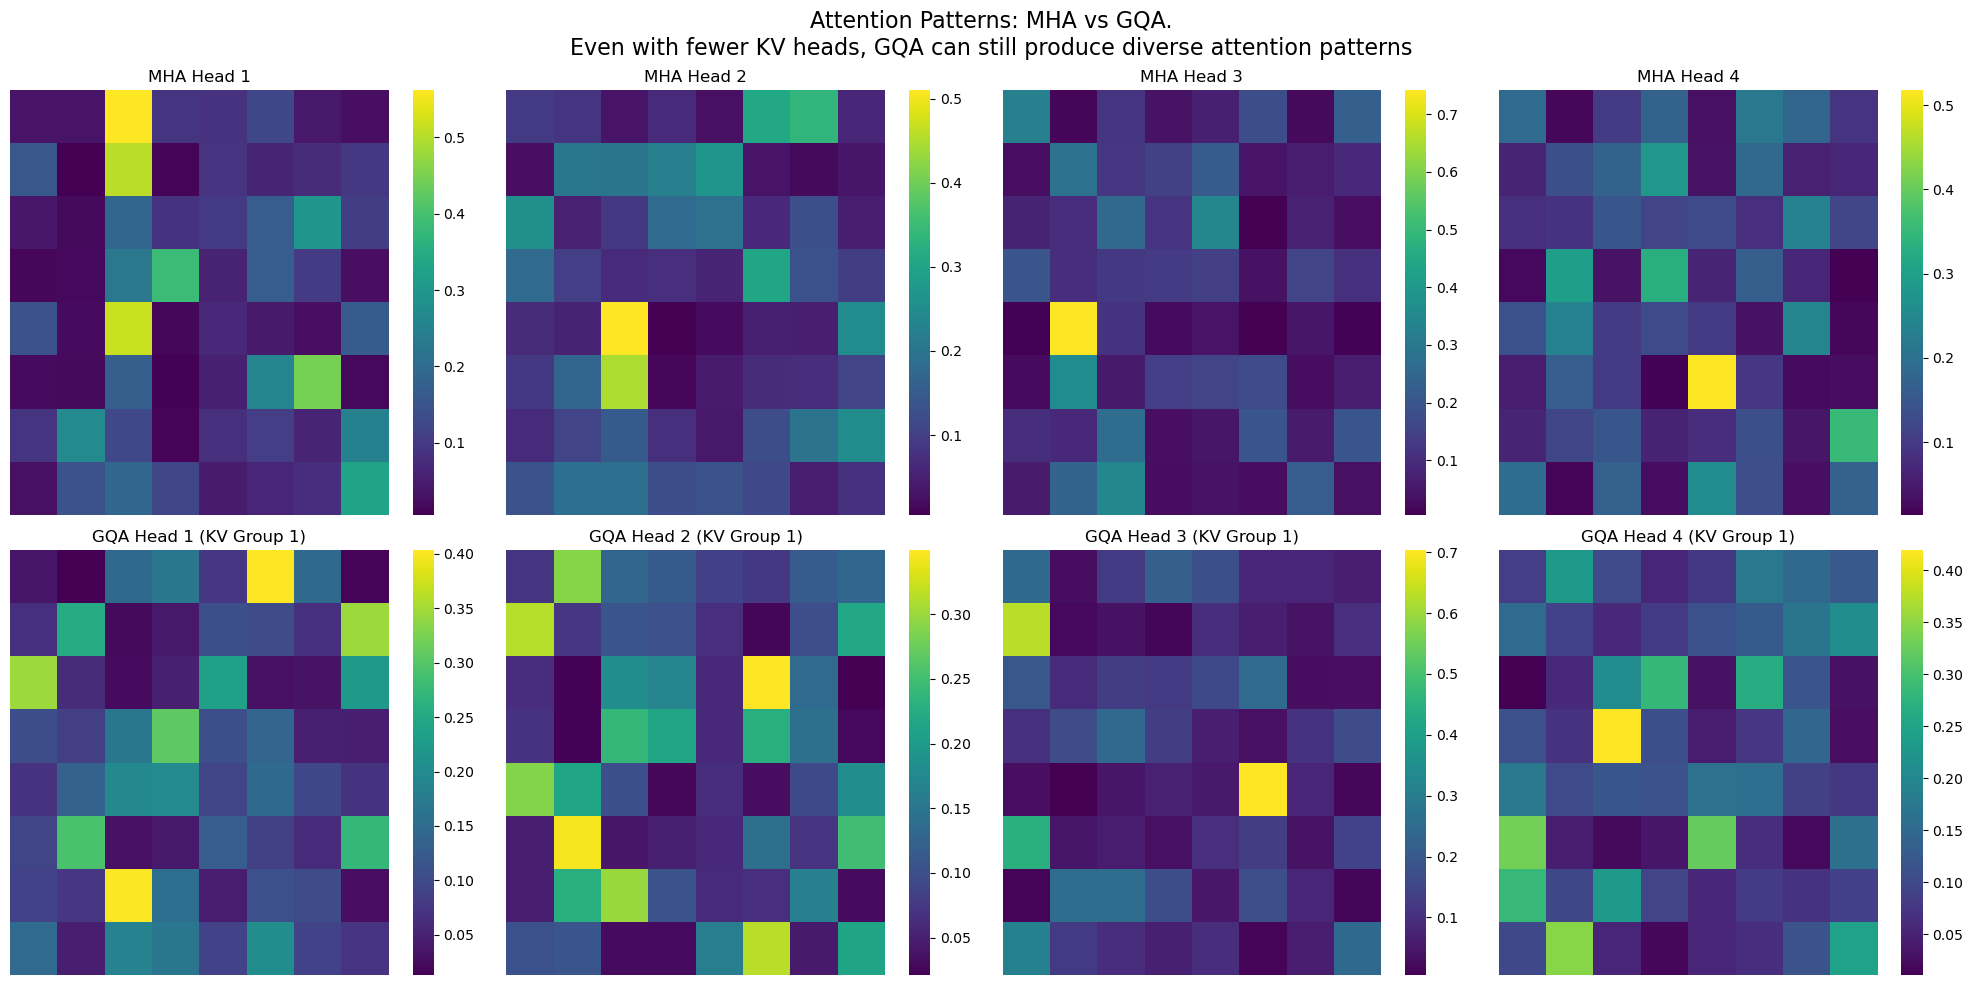

In [39]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_attention_patterns():
    # Set parameters
    batch_size = 1
    seq_len = 8
    d_model = 64
    num_query_heads = 8
    num_kv_heads = 2
    head_dim = d_model // num_query_heads
    
    # Create dummy Q, K tensors
    # MHA: separate K for each head
    mha_q = torch.randn(batch_size, num_query_heads, seq_len, head_dim)
    mha_k = torch.randn(batch_size, num_query_heads, seq_len, head_dim)
    
    # GQA: shared K for groups of heads
    gqa_q = torch.randn(batch_size, num_query_heads, seq_len, head_dim)
    gqa_k = torch.randn(batch_size, num_kv_heads, seq_len, head_dim)
    # Repeat KV heads to match number of query heads
    gqa_k = gqa_k.repeat_interleave(num_query_heads // num_kv_heads, dim=1)
    
    # Compute attention scores
    mha_scores = torch.matmul(mha_q, mha_k.transpose(-1, -2)) / (head_dim ** 0.5)
    gqa_scores = torch.matmul(gqa_q, gqa_k.transpose(-1, -2)) / (head_dim ** 0.5)
    
    # Apply softmax
    mha_attention = torch.softmax(mha_scores, dim=-1)
    gqa_attention = torch.softmax(gqa_scores, dim=-1)
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Attention Patterns: MHA vs GQA. \nEven with fewer KV heads, GQA can still produce diverse attention patterns.', \
                 fontsize=16)
    
    # Plot first 4 heads for each
    for i in range(4):
        # MHA patterns
        sns.heatmap(mha_attention[0, i].detach(), 
                   ax=axes[0, i], 
                   cmap='viridis',
                   xticklabels=False,
                   yticklabels=False)
        axes[0, i].set_title(f'MHA Head {i+1}')
        
        # GQA patterns
        sns.heatmap(gqa_attention[0, i].detach(), 
                   ax=axes[1, i], 
                   cmap='viridis',
                   xticklabels=False,
                   yticklabels=False)
        axes[1, i].set_title(f'GQA Head {i+1} (KV Group {i//(num_query_heads//num_kv_heads) + 1})')
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_attention_patterns()